# Data Analysis

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import batched
from utils.data import (
    Datasets,
    FULL_SEQUENCE_LENGTH,
    TEST_INDICIES,
    IMAGE_SHAPE,
)

from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, norm
from sklearn.decomposition import PCA
from scipy.ndimage import center_of_mass

from IPython.display import display_latex

mpl.rcParams["figure.dpi"] = 300

ds = Datasets("/Users/henrywilliams/Documents/uni/amml/assessment/data")

n6 = ds.n6_full().numpy()
n3 = ds.n3_full().numpy()

data = n6

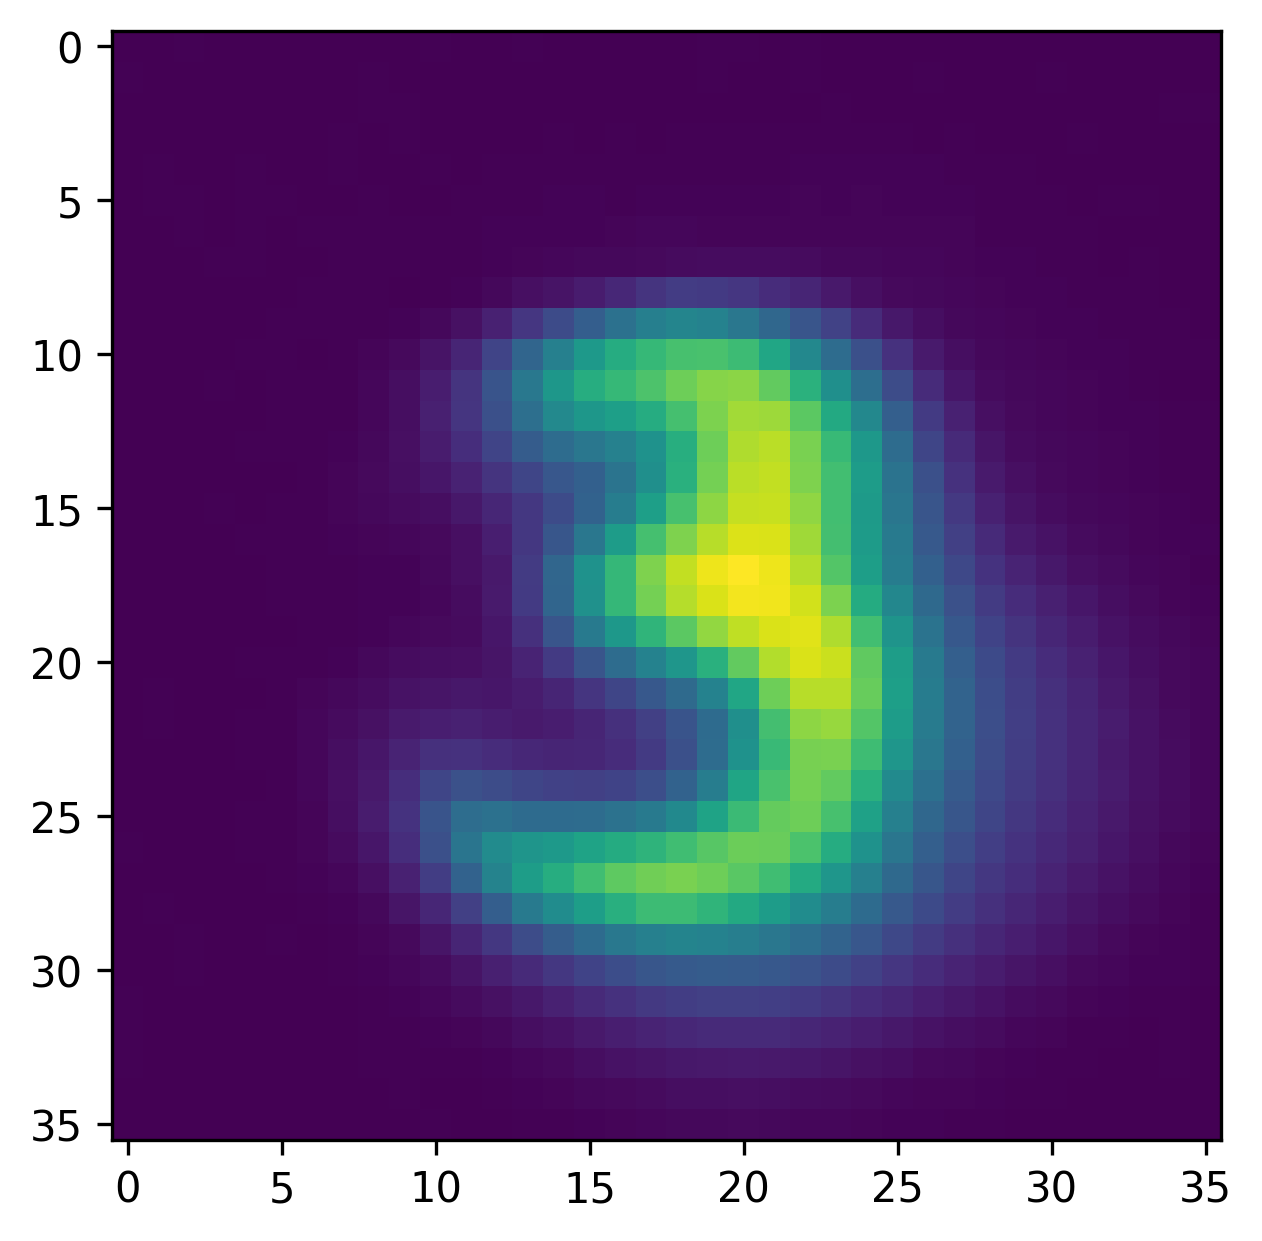

In [31]:
plt.imshow(np.sum(data, axis=(0, 1)))

In [32]:
# mu_n6 = np.mean(n6.numpy().mean())
# std_n6 = np.mean(n6.numpy().std())

# mu_n3 = np.mean(n3.numpy().mean())
# std_n3 = np.mean(n3.numpy().std())

# print(f"N6:\nμ = {mu_n6}\tσ = {std_n6}")
# print(f"N3:\nμ = {mu_n3}\tσ = {std_n3}")

87

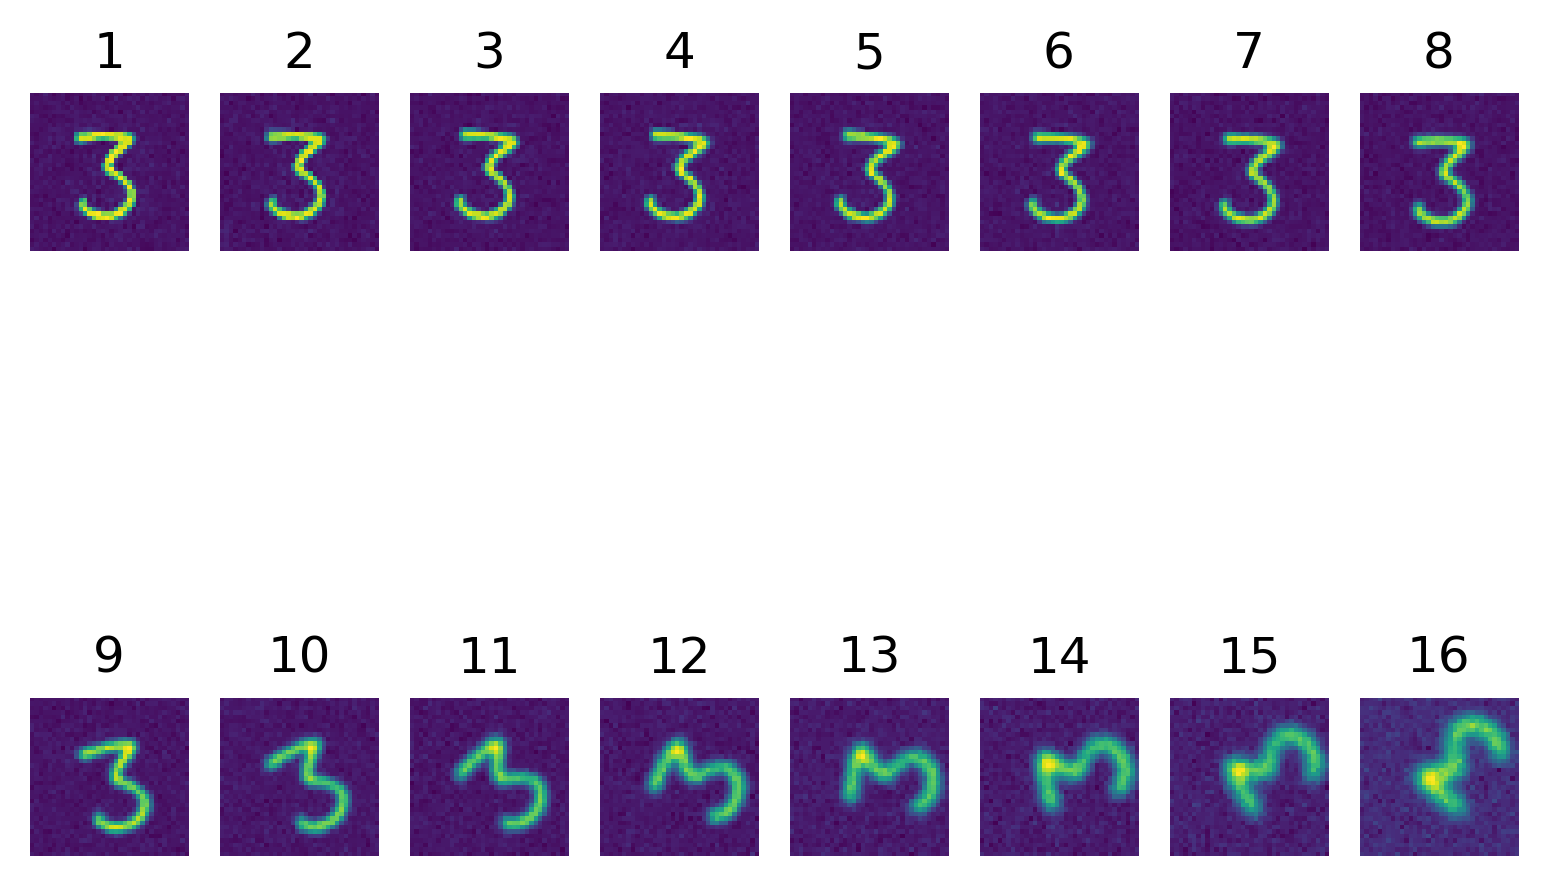

In [33]:
def plot_full_sequence(sequence, plot_test: bool = True):
    fig, axs = plt.subplots(2, 8)

    for i in range(FULL_SEQUENCE_LENGTH):
        if i in TEST_INDICIES and not plot_test:
            axs[i // 8][i % 8].imshow(np.zeros(IMAGE_SHAPE))
        else:
            axs[i // 8][i % 8].imshow(sequence[i])
        axs[i // 8][i % 8].axis("off")
        axs[i // 8][i % 8].title.set_text(f"{i + 1}")


idx = np.random.randint(len(data))
print(idx)
plot_full_sequence(data[idx], plot_test=True)

## Difference between images in a sequence

In [43]:
differences = np.array(
    [[next_img - img for img, next_img in batched(sequence, 2)] for sequence in data]
)

differences.shape

(400, 8, 36, 36, 1)

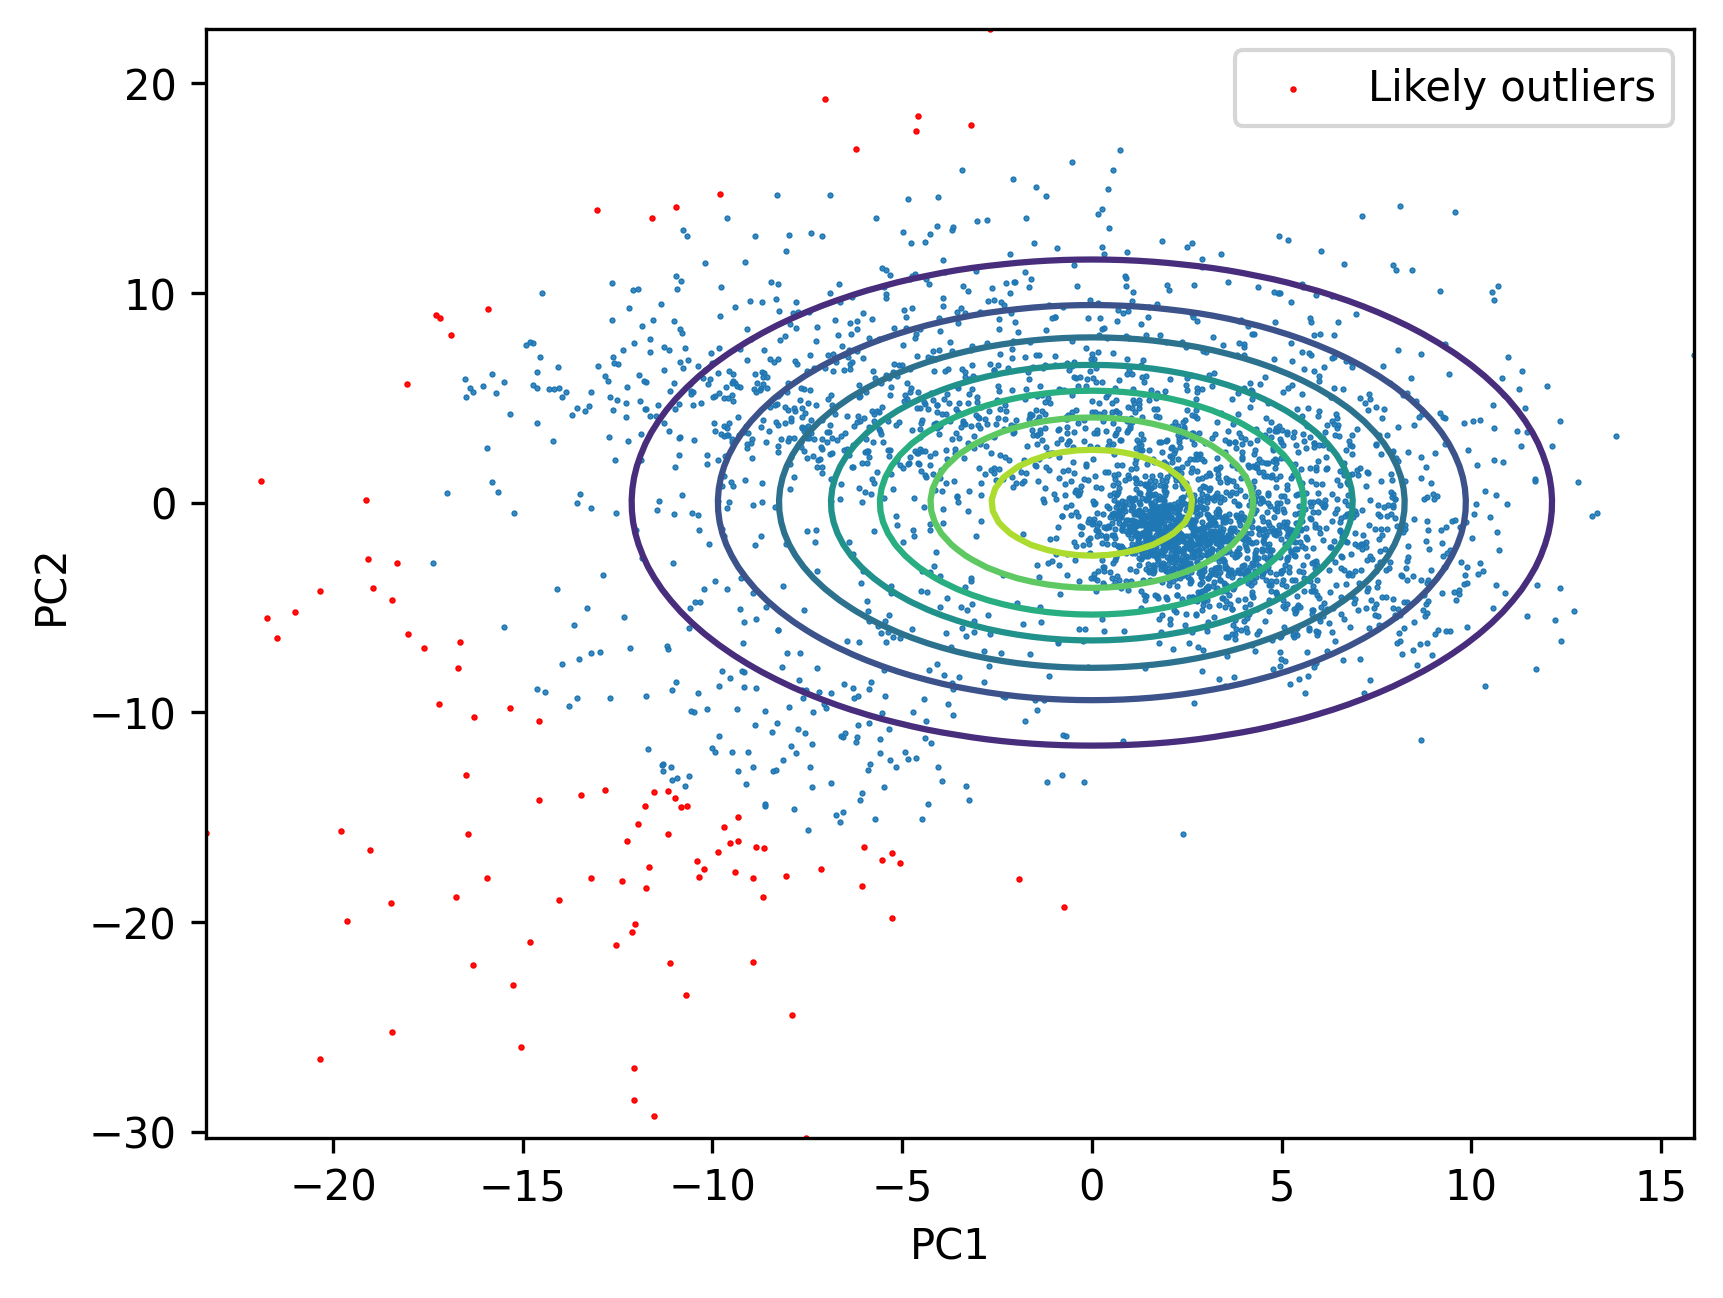

In [44]:
x_scaled = StandardScaler().fit_transform(
    differences.reshape(len(data) * (FULL_SEQUENCE_LENGTH // 2), 1296)
)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_scaled)
X = pca_features[:, 0]
Y = pca_features[:, 1]
d = np.vstack((X, Y)).T
mu = np.mean(d, axis=0)
cov = np.cov(d, rowvar=False)


x = np.linspace(X.min(), X.max(), 100)
y = np.linspace(Y.min(), Y.max(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)


def is_within_dist(points, mu, cov, n=3):
    diff = points - mu
    precision = np.linalg.inv(cov)

    mahalanobis_distances = np.sqrt(np.sum(diff @ precision * diff, axis=1))

    return mahalanobis_distances <= n


a = pca_features[is_within_dist(pca_features, mu, cov)]
b = pca_features[~is_within_dist(pca_features, mu, cov)]

plt.scatter(a[:, 0], a[:, 1], s=0.25)
plt.scatter(b[:, 0], b[:, 1], c="red", s=0.3, label="Likely outliers")

plt.contour(X_grid, Y_grid, Z)
# plt.title("PCA plot of change between images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

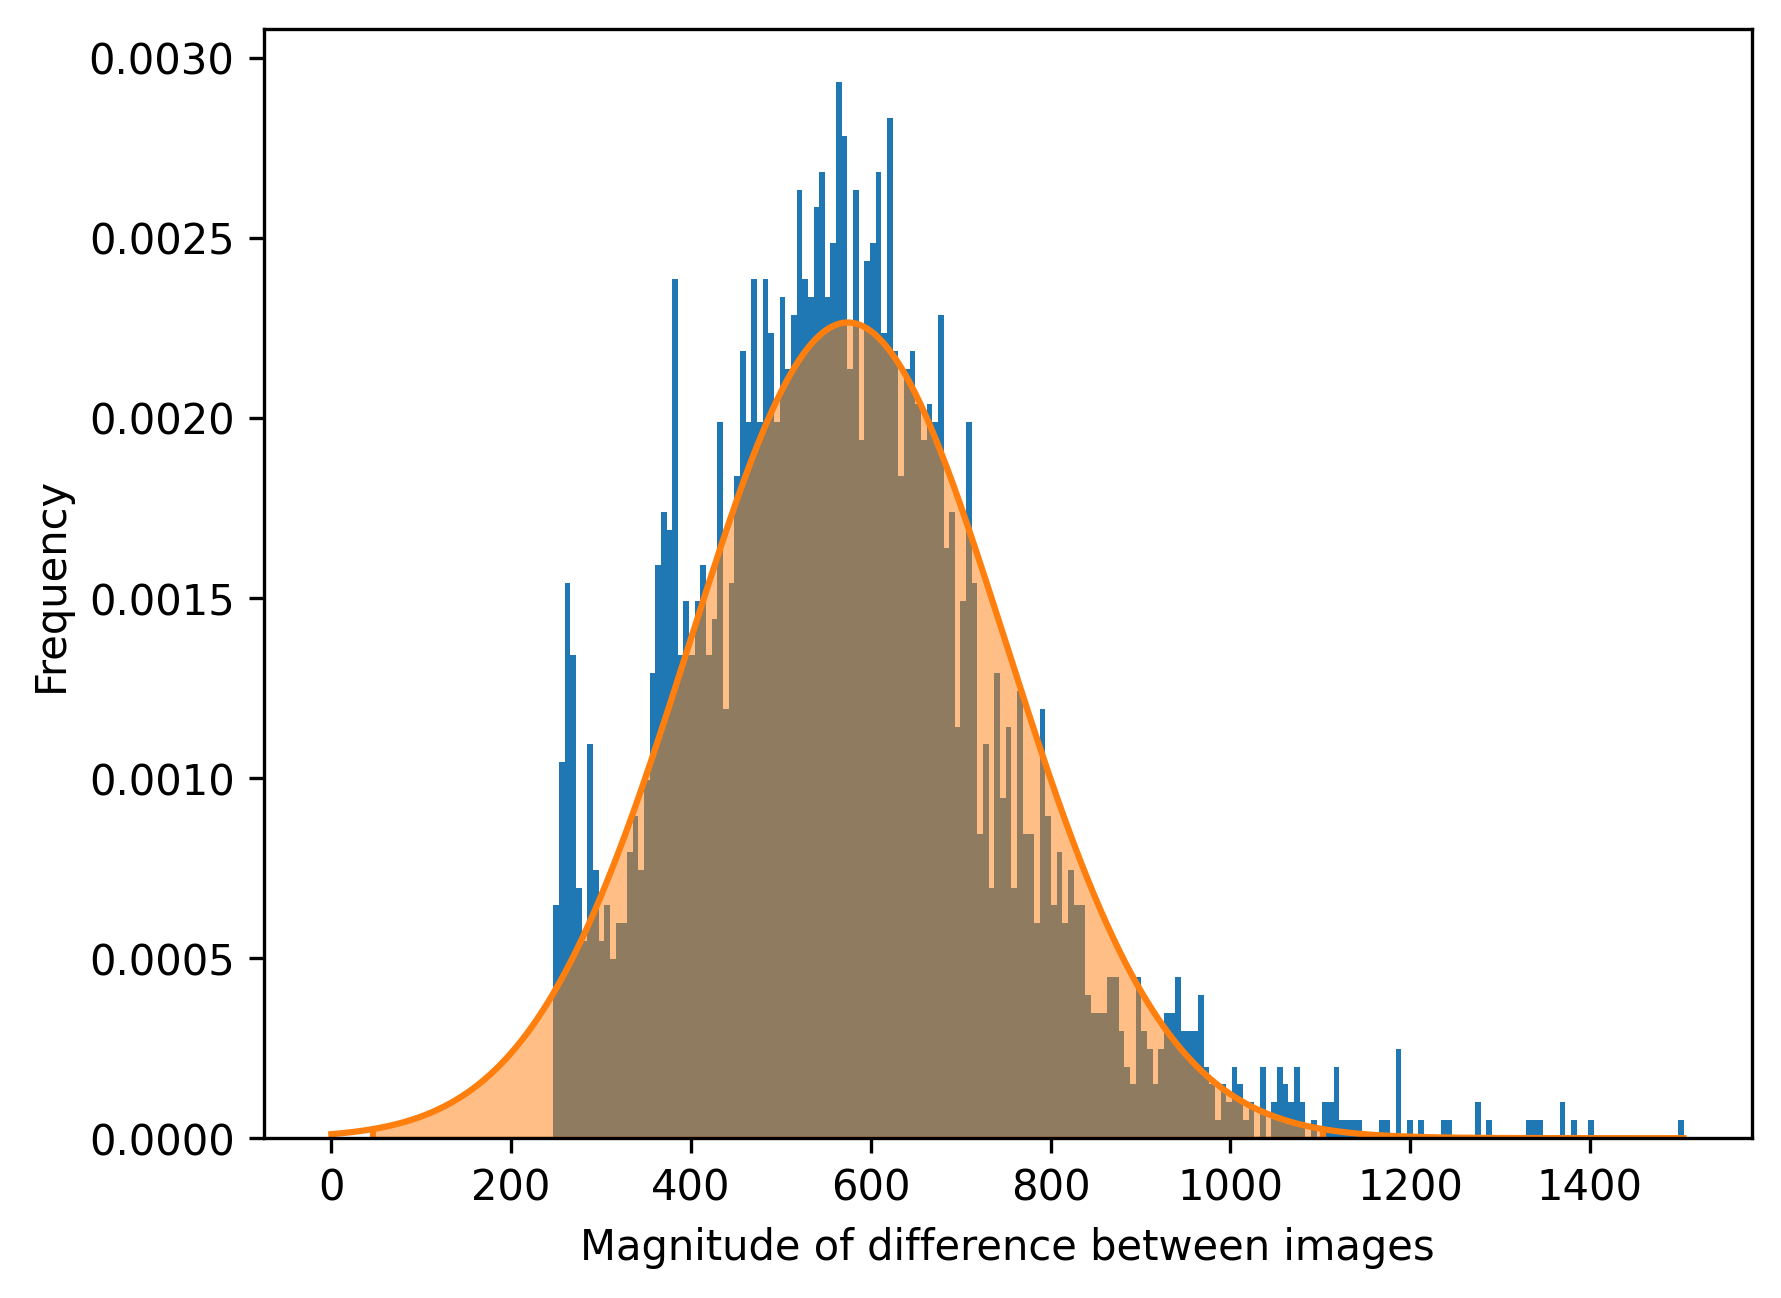

In [46]:
diff_mag = np.linalg.norm(differences, axis=(2, 3)).reshape(-1)
max_change = np.max(diff_mag)
mu, std = norm.fit(diff_mag)
xs = np.arange(0, max_change)
extent = 3
lb = (-extent * std) + mu
ub = (extent * std) + mu
xs_2 = xs[(xs > lb) & (xs < ub)]
p2 = norm.pdf(xs_2, mu, std)

p = norm.pdf(xs, mu, std)
plt.hist(diff_mag, density=True, color="C0", bins=200)
plt.plot(xs, p, color="C1")
plt.fill_between(xs_2, p2, alpha=0.5, color="C1")
plt.vlines(lb, 0, norm.pdf(lb, mu, std), color="C1")
plt.vlines(ub, 0, norm.pdf(ub, mu, std), color="C1")
plt.xlabel("Magnitude of difference between images")
plt.ylabel("Frequency")
plt.show()

In [47]:
outlier_mask = (diff_mag >= lb) & (diff_mag <= ub)
print(
    f"Found {len(diff_mag) - np.count_nonzero(outlier_mask)} potentially anomalous changes between images"
)

print(
    f"{((len(diff_mag) - np.count_nonzero(outlier_mask)) / len(diff_mag)) * 100:.2f}% of transforms lie outside of 3stdev of mean"
)

Found 33 potentially anomalous changes between images

1.03% of transforms lie outside of 3stdev of mean

Outliers occur in sequences: [11 21 24 34 61 78 87]

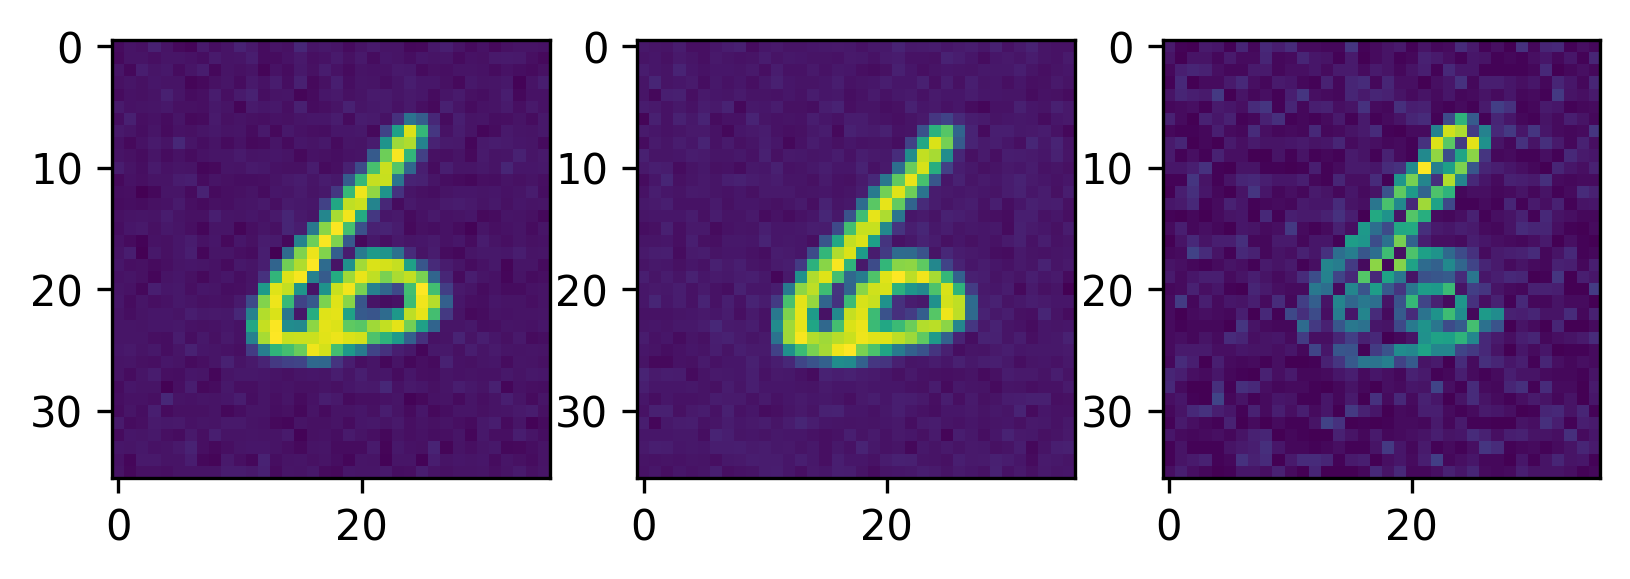

In [38]:
outlier_mask = outlier_mask.reshape(len(data), 8)
outlier_ids, outlier_occurs = np.nonzero(~outlier_mask)
outliers = np.column_stack([outlier_ids, outlier_occurs])
print(f"Outliers occur in sequences: {np.where(~np.all(outlier_mask, axis=1))[0]}")

idx = np.random.choice(outliers[:, 0])
outlier_info = outliers[outliers[:, 0] == idx][0]
outlier_sequence = n6[outlier_info[0]]

orig = outlier_sequence[outlier_info[1]]
trans = outlier_sequence[outlier_info[1] + 1]

plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.subplot(1, 3, 2)
plt.imshow(trans)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(trans - orig))
plt.show()

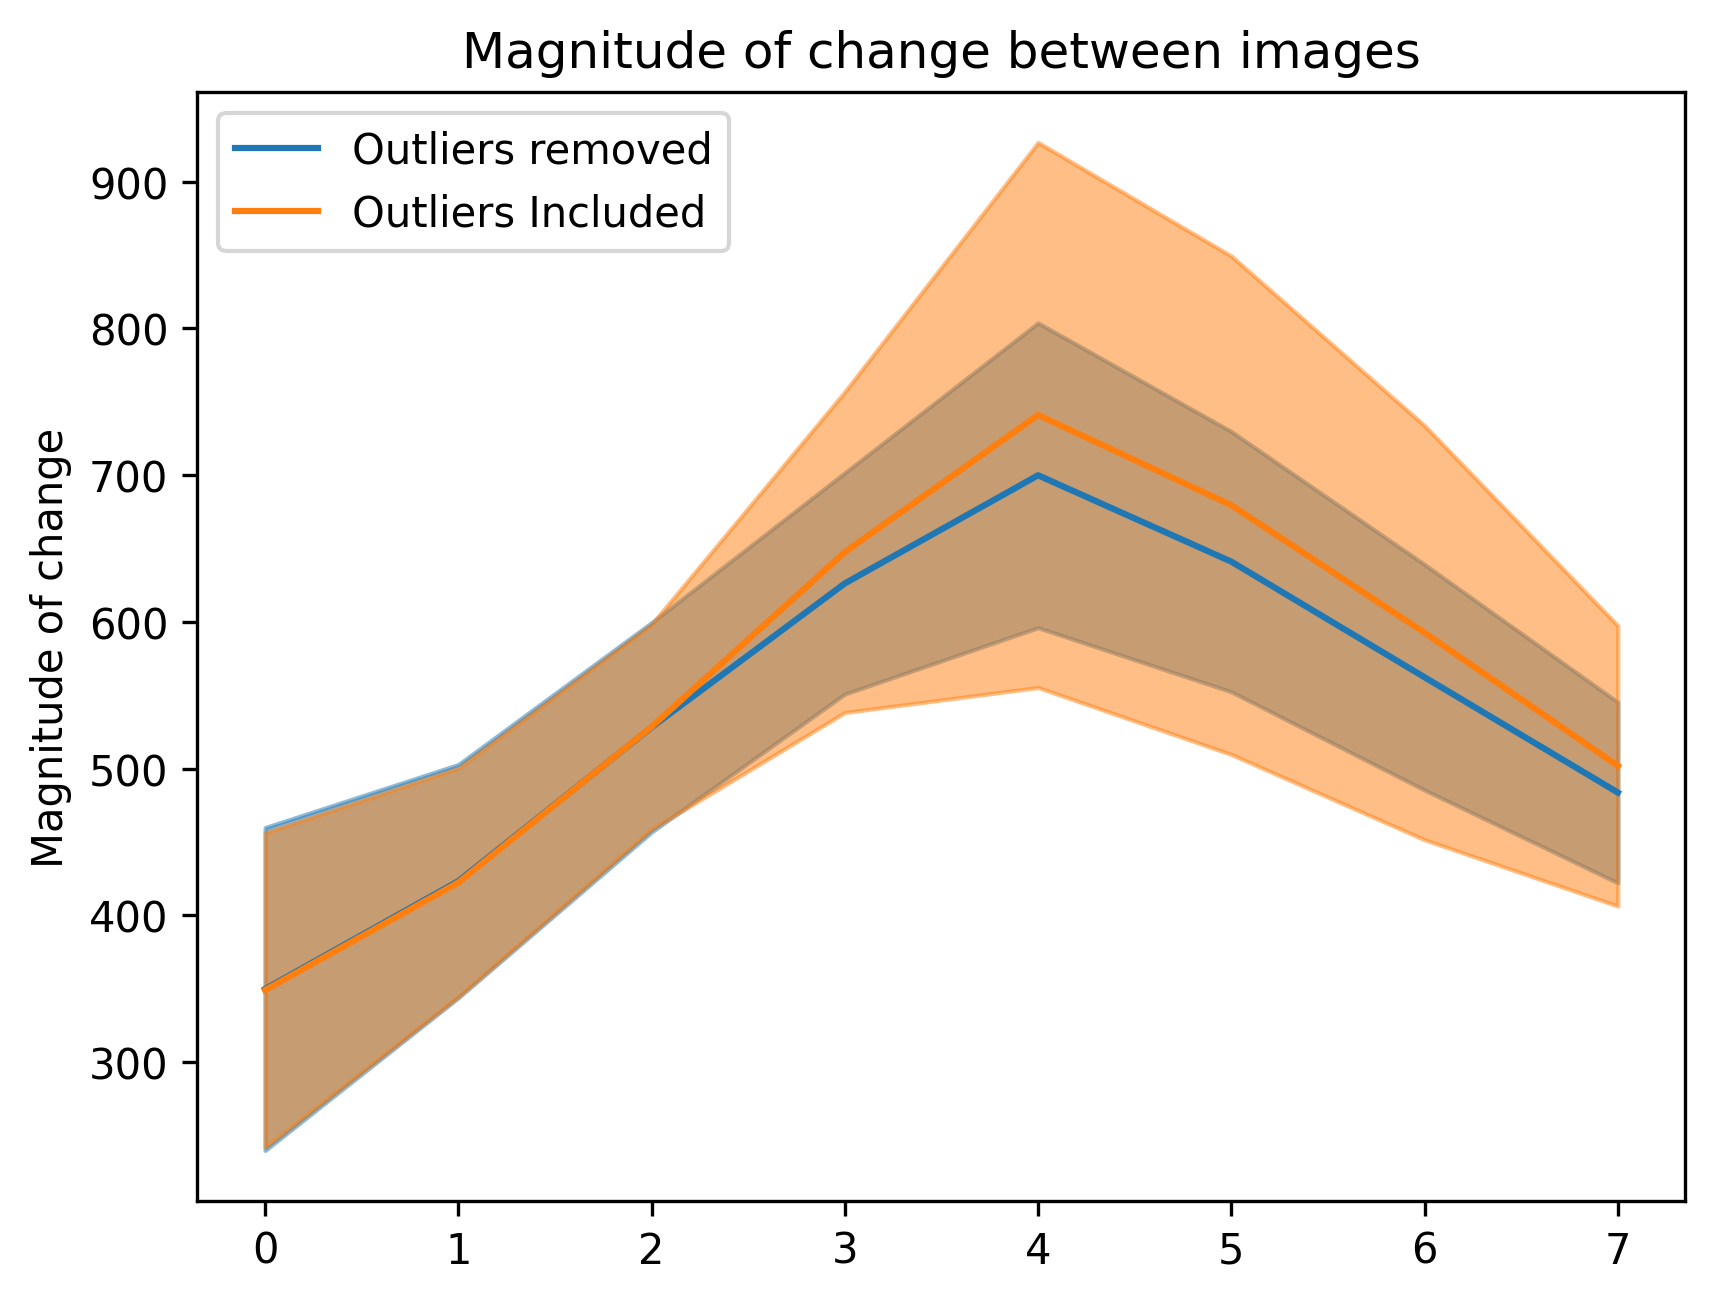

In [39]:
normal_sequences_diff = np.array(
    [differences[id] for id in range(len(data)) if id not in outlier_ids]
)
normal_sequence_mag = np.linalg.norm(normal_sequences_diff, axis=(2, 3))
diff_mag_over_seq = diff_mag.reshape(len(data), 8)
mean_mag = np.mean(normal_sequence_mag, axis=0).reshape(-1)
std_mag = np.std(normal_sequence_mag, axis=0).reshape(-1)
mean_mag_with_outliers = np.mean(diff_mag_over_seq, axis=0).reshape(-1)
std_mag_with_outliers = np.std(diff_mag_over_seq, axis=0).reshape(-1)

plt.title("Magnitude of change between images")
plt.plot(mean_mag, c="C0", label="Outliers removed")
plt.fill_between(
    list(range(8)), mean_mag - std_mag, mean_mag + std_mag, alpha=0.5, color="C0"
)
plt.plot(mean_mag_with_outliers, label="Outliers Included", c="C1")
plt.fill_between(
    list(range(8)),
    mean_mag_with_outliers - std_mag_with_outliers,
    mean_mag_with_outliers + std_mag_with_outliers,
    alpha=0.5,
    color="C1",
)
plt.ylabel("Magnitude of change")
plt.legend()
plt.show()

In [40]:
import pandas as pd

a = pd.read_csv("/Users/henrywilliams/Documents/uni/amml/assessment/data/n6-test.csv")
i28 = np.array(a.iloc[399]).reshape(36, 36)
imgs = data.reshape(6400, 36, 36)

for idx, i in enumerate(imgs):
    if (i == i28).all():
        print(f"Found in sequence {idx // 16}, image {idx % 16}")
        break

ValueError: cannot reshape array of size 2073600 into shape (6400,36,36)

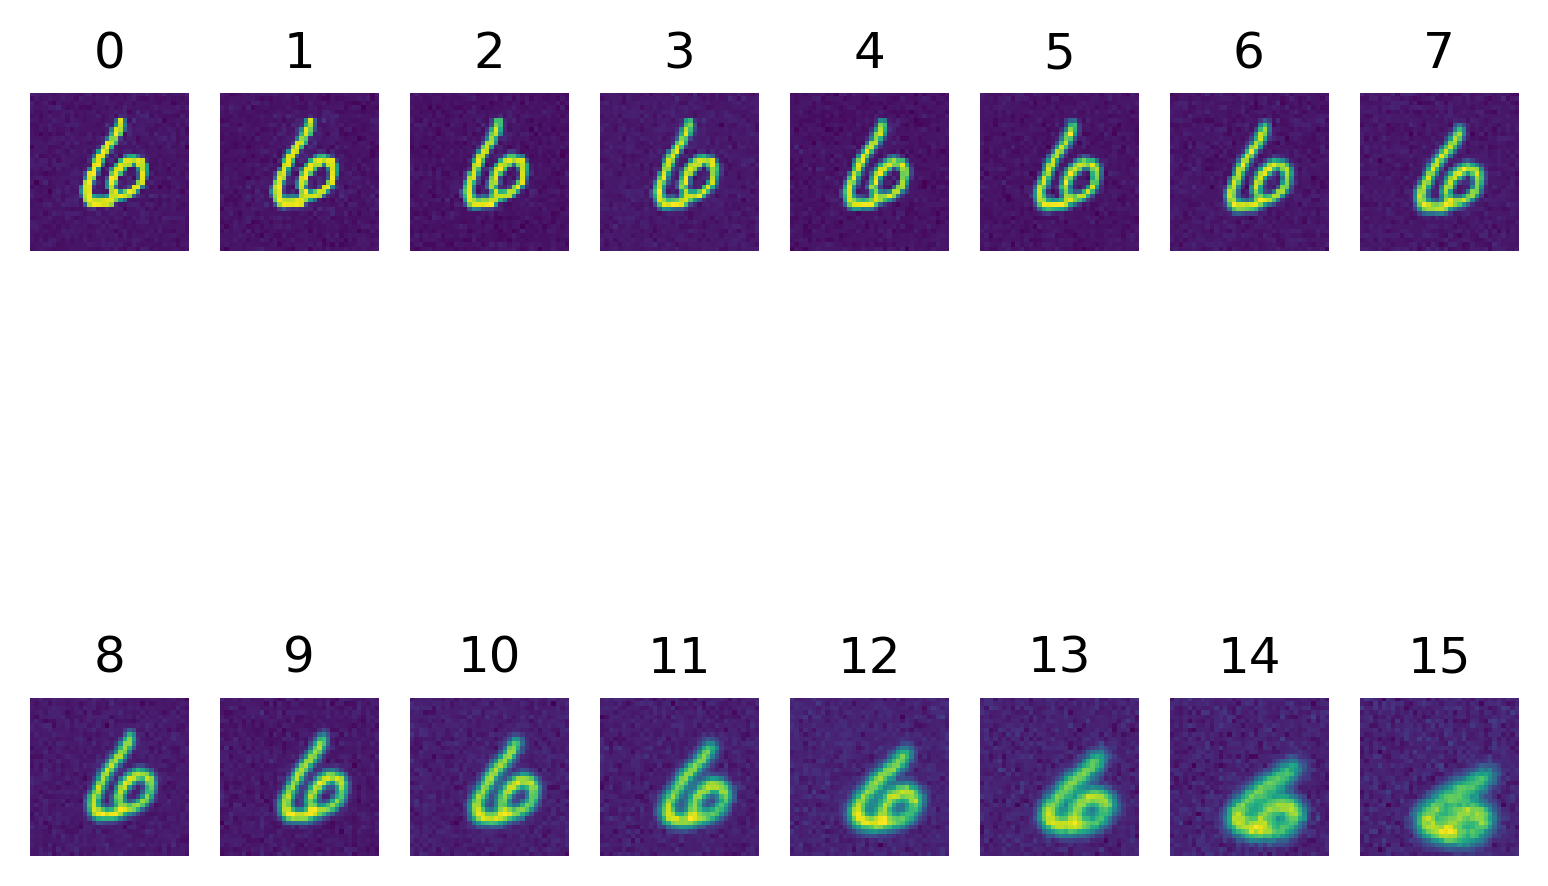

In [13]:
plot_full_sequence(data[idx // 16])

# Noise Removal

([], [])

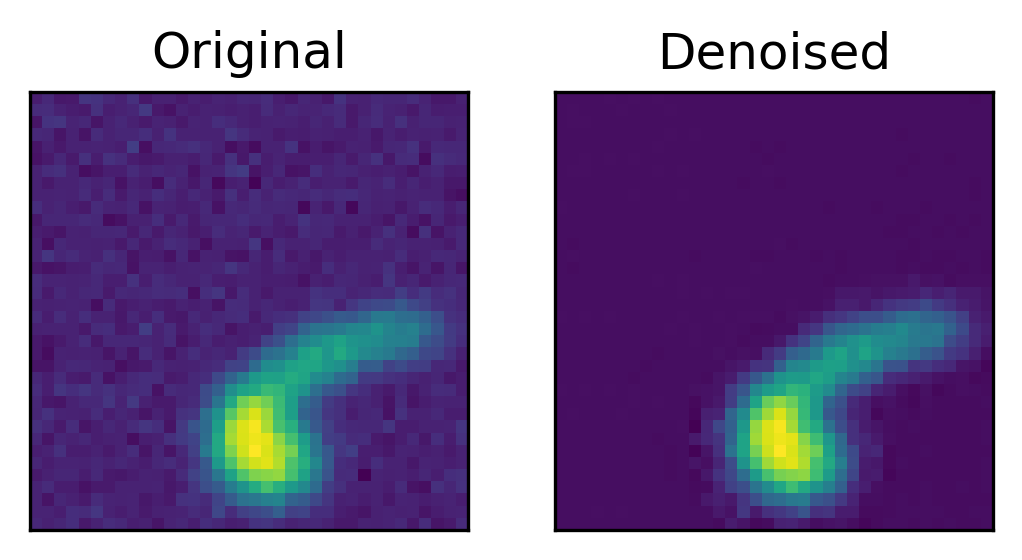

In [48]:
import cv2

idx = np.random.choice(6400)
img = data[idx // 16][idx % 16]

img = np.uint8((img - img.min()) / (img.max() - img.min()) * 255)
denoise = cv2.fastNlMeansDenoising(img, h=8)

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.title("Denoised")
plt.imshow(denoise)
plt.xticks([])
plt.yticks([])
# plt.subplot(1, 3, 3)

# plt.imshow()

(16, 2)

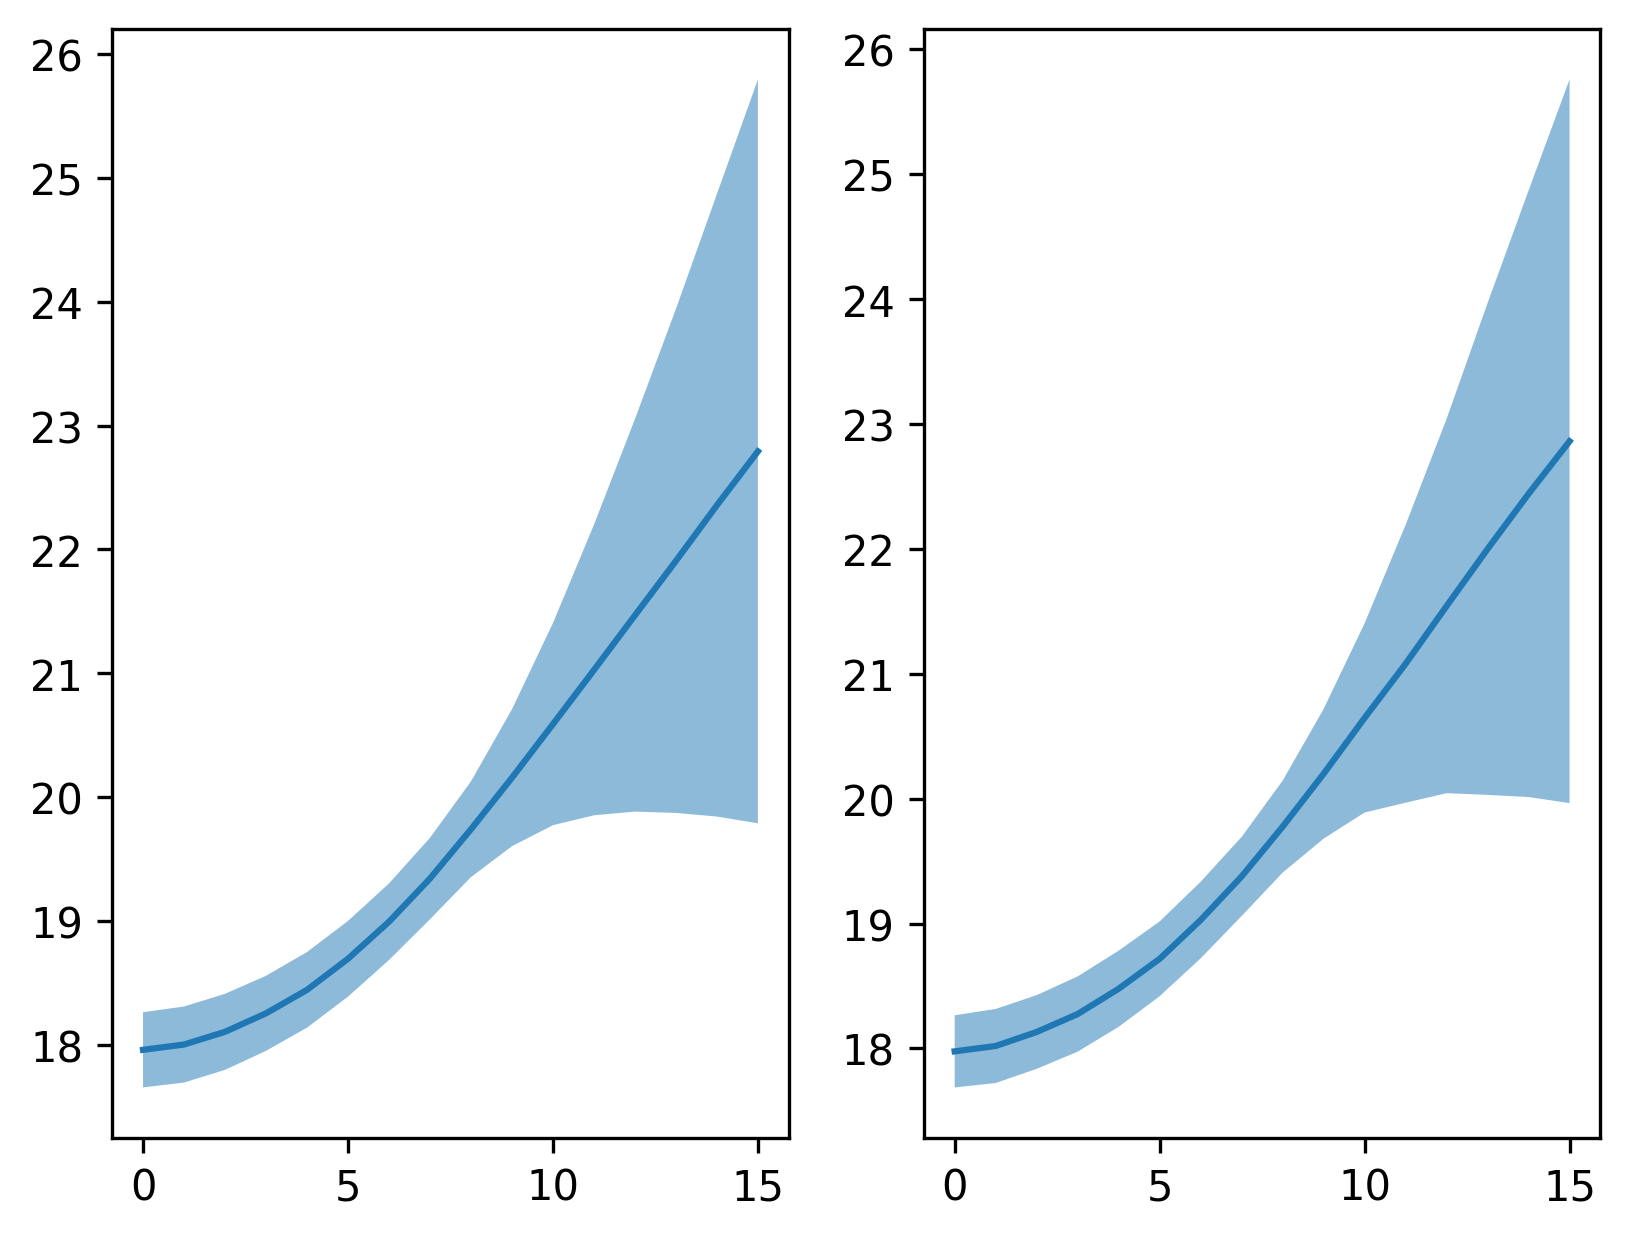

In [ ]:
n6_sequence_com = np.zeros((400, 16, 2))
n3_sequence_com = np.zeros((100, 16, 2))

for i in range(400):
    for j in range(16):
        n6_sequence_com[i, j] = center_of_mass(n6[i, j].reshape(36, 36))
for i in range(100):
    for j in range(16):
        n3_sequence_com[i, j] = center_of_mass(n3[i, j].reshape(36, 36))

mu_com_n6 = n6_sequence_com.mean(axis=(0, 2))
std_com_n6 = n6_sequence_com.std(axis=(0, 2))
mu_com_n3 = n3_sequence_com.mean(axis=(0, 2))
std_com_n3 = n3_sequence_com.std(axis=(0, 2))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 16), mu_com_n6)
plt.fill_between(
    np.arange(0, 16), mu_com_n6 - std_com_n6, mu_com_n6 + std_com_n6, alpha=0.5
)
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 16), mu_com_n3)
plt.fill_between(
    np.arange(0, 16), mu_com_n3 - std_com_n3, mu_com_n3 + std_com_n3, alpha=0.5
)

In [5]:
import pandas as pd

n6_test_actual = pd.read_csv(
    "/Users/henrywilliams/Documents/uni/amml/assessment/data/n6-test.csv"
).to_numpy()
n6_test_pred = pd.read_csv(
    "/Users/henrywilliams/Documents/uni/amml/assessment/conv-lstm/n6_test_results.csv"
).to_numpy()

n3_test_actual = pd.read_csv(
    "/Users/henrywilliams/Documents/uni/amml/assessment/data/n3-test.csv"
).to_numpy()
n3_test_pred = pd.read_csv(
    "/Users/henrywilliams/Documents/uni/amml/assessment/conv-lstm/n3_test_results.csv"
).to_numpy()